# Dictionary Counting Script

Finds the number of occurences of a dictionary phrase in the webtext of a school. Creates column for number of webtext words, ratio of hits, and hit strength(log of ratio)

## Import packages

In [2]:
import pandas as pd
import re
import numpy as np
import time
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import multiprocessing as mp

# For loading functions from files in data_tools directory:
import sys; sys.path.insert(0, "../../data_management/tools/")

In [3]:
# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

# For calculating densities, years opened and closed, and school closure rates:
from df_calc import count_pdfs, density_calc, openclose_calc, closerate_calc

## Load data

In [4]:
charter_path = '../../misc_data/charters_2015.pkl'
df_charter1 = load_filtered_df(charter_path, ["WEBTEXT", "NCESSCH"])
df_charter1['WEBTEXT']=df_charter1['WEBTEXT'].fillna('') # turn nan to empty iterable for future convenience

stemmer = PorterStemmer()
stem = stemmer.stem # stemmer function

# rows and cols:  (10965, 3)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
NUMWORDS
WEBTEXT


In [6]:
df_charter1

,NCESSCH,NUMWORDS,WEBTEXT
0,1.001970e+10,17929.0,"[(http://www.maef.net/, False, 0, Evening Acad..."
1,2.000010e+10,0.0,
2,2.001500e+10,1330.0,"[(https://www.kgbsd.org/ketchikancharter, Fals..."
3,2.001500e+10,28279.0,[(http://tongassschool.org/classrooms/3rd-and-...
4,2.001800e+10,563.0,"[(https://www.asdk12.org/aquarian, False, 0, S..."
5,2.001800e+10,0.0,
6,2.001800e+10,0.0,
7,2.001800e+10,0.0,
8,2.001800e+10,15529.0,"[(http://winterberrycharterschool.com/, False,..."
9,2.001800e+10,1.0,[(https://www.asdk12.org/aboutschools/eagleaca...


In [7]:
dict_path = '/home/jovyan/work/text_analysis/dictionary_methods/dicts/'
file_ext = '.txt'
dict_names = ['inquiry30', 'discipline30'] # enter list of names of txt files holding dict

## Define functions for counting dictionaries

In [12]:
# loads dictionaries into list
# completes dictionary to include entries with dashes taken out
def load_dict():
    dict_list = []
    for name in dict_names:
        with open(dict_path+name+file_ext) as f: 
            new_dict = f.read().splitlines()
            new_words = []
            for entry in new_dict:
                new_words.append(re.sub(' +|/+|-+|_+', '', entry))
            new_dict.extend(new_words)
            new_dict = set(new_dict)
            dict_list.append(list(new_dict))
    return dict_list

In [13]:
dict_list = load_dict()
dict_list

[['explorationandexperimentation',
  'constructivist',
  'problembased',
  'experiential',
  'exploration_and_experimentation',
  'student-centered',
  'projectbased',
  'inquiry-based',
  'discoverybased',
  'childcentered',
  'handsonlearning',
  'hands-on_and_minds-on',
  'inquirybased',
  'student-centered_inquiry-based',
  'inquirydriven',
  'active_inquiry',
  'problem-based',
  'hand-on',
  'hands-on',
  'learner-centered',
  'learn-by-doing',
  'socratic_method',
  'learnercentered',
  'socratic_dialogue',
  'studentdrivenexploration',
  'studentcentered',
  'handsonmindson',
  'prbl',
  'child-centered',
  'projectcentered',
  'handon',
  'studentcenteredinquirybased',
  'handson',
  'experiential_approach',
  'project-centered',
  'activeinquiry',
  'experientially',
  'discovery-based',
  'hands-on_learning',
  'learnbydoing',
  'handsonandmindson',
  'socraticmethod',
  'project-based',
  'inquiry-driven',
  'socraticdialogue',
  'laboratorybased',
  'constructivism',
  'so

In [19]:
class Page:
    def __init__(self,p):
        self.url = p[0]
        self.boo = p[1]
        self.depth = p[2]
        self.text = p[3]
    def __repr__(self):
        return self.text
    def __eq__(self, other):
        if isinstance(other, Page):
            return self.text == other.text
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.__repr__())
    
def dict_precalc(dict_list, stemset):
    precalc_list = []
    for keywords in dict_list:  
        large_words = []
        large_lengths = []
        large_first_words = []
        key_words = []
        for entry in keywords:
            if stemset:
                word = [stem(x) for x in re.split('\W+|_', entry.lower())]
            else:
                word = re.split('\W+|_', entry.lower())
            key_words.append(word) # listified version of each keyword
            if len(word) >= 3:
                large_words.append(word) # contains only large entries(>2 word)
                large_lengths.append(len(word))
                large_first_words.append(word[0]) # first words of each large entry in dict
        precalc_list.append([large_words, large_lengths, large_first_words, key_words])
    return precalc_list

def dict_count2(key_words, large_words, large_lengths, large_first_words, pages):

    """Returns the hit count with given dictionary on page set.

    pages: set of preprocessed page lists corresponding to an entry of the 'webtext' column
    """
    counts = 0 # number of matches between text_list and custom_dict
    res_length = 0
    # Do dictionary analysis for word chunks of lengths max_entry_length down to 1
    for splitted_phrase in pages:
        for length in range(1, 3):
            if len(splitted_phrase) < length:
                continue # If text chunk is shorter than length of dict entries being matched, there are no matches.
            for i in range(len(splitted_phrase) - length + 1):
                entry = splitted_phrase[i:i+length]
                if entry in key_words:
                    counts += 1
                    res_length += length - 1
        indices = np.transpose(np.nonzero([np.array(splitted_phrase) == first_word for first_word in large_first_words]))
        for ind in indices:
            if ind[1] <= (len(splitted_phrase) - large_lengths[ind[0]]) and large_words[ind[0]] == splitted_phrase[ind[1] : ind[1] + large_lengths[ind[0]]]:
                counts += 1
                res_length += large_lengths[ind[0]] - 1
    return counts, res_length

In [20]:
def create_cols(df_charter, stemset = 0):
    
    """Creates count, ratio, and strength columns for each dictionary file with [FILE_NAME]_COUNT/RATIO/STR as column name. 
    
    Returns modified dataframe
    stemset: 1 for stemming before matching, 0 for no stemming
    Sets strengths with zero hit count to -6
    """
    dict_list = load_dict()
    counts = [[] for _ in range(len(dict_list))]
    res_list = [[] for _ in range(len(dict_list))]
    num_words = [] # WARNING: hitcount/numwords will not give accurate hit ratio in case of multiple word entries. Calculated strength variables do account for this however.
    precalc_list = dict_precalc(dict_list, stemset)
    start = time.time()
    for i, row in enumerate(df_charter['WEBTEXT'].values):
        pages = set([Page(p) for p in row])
        if stemset:
            pages = [[stem(x) for x in re.split('\W+|_', p.text)] for p in pages] # preprocess pages in same way as dictionaries should have been in above precalc function
        else:
            pages = [re.split('\W+|_', p.text) for p in pages]
        num_words.append(sum([len(p) for p in pages]))
        for j, d in enumerate(dict_list):
            c, res = dict_count2(precalc_list[j][3], precalc_list[j][0], precalc_list[j][1], precalc_list[j][2], pages)
            counts[j].append(c)
            res_list[j].append(res)
        if i%1000 == 0:
            end = time.time()
            print('Time Elapsed:{:f}, Percent Complete:{:f}'.format(end - start,i*100/len(df_charter)))
            
    df_charter['NUMWORDS'] = np.array(num_words)
    for i, name in enumerate(dict_names):
        df_charter['{}_COUNT'.format(name.upper())] = np.array(counts[i])
        df_charter['{}_RATIO'.format(name.upper())] = np.array(counts[i])/(np.array(num_words) - np.array(res_list[i]))
        df_charter['{}_STR'.format(name.upper())] = np.log10(np.array(counts[i]))/np.log10(np.array(num_words) - np.array(res_list[i]))
    df_charter.replace([np.inf, -np.inf], -6, inplace = True)
    return df_charter

## Count dictionaries across documents

In [30]:
#SLOW VERSION - no multiprocessing, run with no stem:
#df_new = create_cols(df_charter1, stemset = 0)

In [22]:
# run in parallel using default settings (no stemming)
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    results = pool.map(create_cols(stemset = 0), [df_charter1[300*i:i*300+300] for i in range(round(len(df_charter1)/300)+1)])

Time Elapsed:0.099467, Percent Complete:0.000000
Time Elapsed:0.000998, Percent Complete:0.000000
Time Elapsed:0.000706, Percent Complete:0.000000
Time Elapsed:0.065411, Percent Complete:0.000000
Time Elapsed:0.000685, Percent Complete:0.000000
Time Elapsed:0.021872, Percent Complete:0.000000
Time Elapsed:0.085530, Percent Complete:0.000000
Time Elapsed:0.000647, Percent Complete:0.000000
Time Elapsed:0.049439, Percent Complete:0.000000
Time Elapsed:0.000674, Percent Complete:0.000000
Time Elapsed:0.000679, Percent Complete:0.000000
Time Elapsed:0.031449, Percent Complete:0.000000
Time Elapsed:0.000920, Percent Complete:0.000000
Time Elapsed:0.115108, Percent Complete:0.000000
Time Elapsed:0.226987, Percent Complete:0.000000
Time Elapsed:0.000827, Percent Complete:0.000000
Time Elapsed:0.061025, Percent Complete:0.000000
Time Elapsed:0.000787, Percent Complete:0.000000
Time Elapsed:0.000856, Percent Complete:0.000000
Time Elapsed:0.257611, Percent Complete:0.000000
Time Elapsed:0.07109

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.549718, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.003150, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.003174, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.000166, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.030958, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.067889, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.006225, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.000220, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.000192, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.020197, Percent Complete:0.000000
Time Elapsed:0.002299, Percent Complete:0.000000
Time Elapsed:0.213137, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


Time Elapsed:0.000207, Percent Complete:0.000000
Time Elapsed:0.023322, Percent Complete:0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/

In [41]:
df_new = pd.concat(results)
df_new

,NCESSCH,NUMWORDS,WEBTEXT,INQUIRY30_COUNT,INQUIRY30_RATIO,INQUIRY30_STR,DISCIPLINE30_COUNT,DISCIPLINE30_RATIO,DISCIPLINE30_STR
0,1.001970e+10,17929.0,"[(http://www.maef.net/, False, 0, Evening Acad...",3.0,0.000167,0.112172,1.0,0.000056,0.000000
1,2.000010e+10,0.0,,0.0,NaN,NaN,0.0,NaN,NaN
2,2.001500e+10,1330.0,"[(https://www.kgbsd.org/ketchikancharter, Fals...",0.0,0.000000,-6.000000,1.0,0.000752,0.000000
3,2.001500e+10,28279.0,[(http://tongassschool.org/classrooms/3rd-and-...,3.0,0.000106,0.107184,0.0,0.000000,-6.000000
4,2.001800e+10,563.0,"[(https://www.asdk12.org/aquarian, False, 0, S...",0.0,0.000000,-6.000000,0.0,0.000000,-6.000000
5,2.001800e+10,0.0,,0.0,NaN,NaN,0.0,NaN,NaN
6,2.001800e+10,0.0,,0.0,NaN,NaN,0.0,NaN,NaN
7,2.001800e+10,0.0,,0.0,NaN,NaN,0.0,NaN,NaN
8,2.001800e+10,15529.0,"[(http://winterberrycharterschool.com/, False,...",0.0,0.000000,-6.000000,3.0,0.000193,0.113840
9,2.001800e+10,1.0,[(https://www.asdk12.org/aboutschools/eagleaca...,0.0,0.000000,-6.000000,0.0,0.000000,-6.000000


## Inspect results

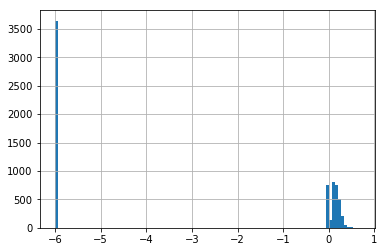

In [44]:
# Show the distribution for strength. Notice there are many -6, which is due to many zeroes in hit count:
%matplotlib inline
import matplotlib.pyplot as plt

df_new["INQUIRY30_STR"].hist(bins=100)

## Save results

In [43]:
# Drop WEBTEXT to keep file size small:
df_new.drop(columns = "WEBTEXT", inplace=True)
list(df_new)

['NCESSCH',
 'NUMWORDS',
 'INQUIRY30_COUNT',
 'INQUIRY30_RATIO',
 'INQUIRY30_STR',
 'DISCIPLINE30_COUNT',
 'DISCIPLINE30_RATIO',
 'DISCIPLINE30_STR']

In [45]:
df_new.to_csv('../../charter_data/dict_counts/30counts_2015_250_v2a.csv')